In [1]:
# --- Setup & Imports ----------------------------------------------------------
import numpy as np
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import seaborn as sns
import os, sys
import pickle
from scipy import stats
import scipy.io as sio
from scipy.io import loadmat
import pandas as pd
from scipy.stats import pearsonr, linregress
# Point Python to your src/ folder
sys.path.append(os.path.abspath("../src"))

from preprocessing import *
from NPI import *
from group_analysis import *
from connectivity import *


# Import Connectome and Atlas data

In [2]:
# Define base path (adjust depending on where you run the notebook)
base_dir = os.path.abspath('..')  # go one level up from /notebooks
data_dir = os.path.join(base_dir, 'data', 'connectome')

# Load .mat files
#path_AAL = os.path.join(data_dir, 'AAL_labels_complete_symmetric.mat')
path_PET = os.path.join(data_dir, 'Hansen_NM_PET_Maps.mat')
path_RSN = os.path.join(data_dir, 'RSNsAAL_non-symmetric.mat')
path_SC  = os.path.join(data_dir, 'SC.mat')

#AAL_labels = loadmat(path_AAL)
PET_maps   = loadmat(path_PET)
RSNsAAL    = loadmat(path_RSN)
SC_mat         = loadmat(path_SC)

# Resting State Networks
RSNs_labels = ['Visual', 'Somatomotor', 'Dorsal Attn', 'Sal-VentAttn', 'Limbic', 'Control', 'Default']

RSN_probs=RSNsAAL['Yeo_AAL']
RSN_probs=RSN_probs.astype(float)
for i in range(7):
    RSN_probs[i]=RSN_probs[i]/np.max(RSN_probs[i])
    
# 1. Assign each ROI to the RSN with maximum probability (0–6)
RSNs_max_prob = np.argmax(RSN_probs, axis=0)  # shape (90,)
# 2. Reorder ROIs so that all Left (L) come before Right (R) as in [L0, L1, ..., LN, RN, ...,R1, R0]
L_ids = np.arange(0, 90, 2)
R_ids = np.arange(1, 90, 2)
RSNs = np.concatenate([RSNs_max_prob[L_ids], RSNs_max_prob[R_ids][::-1]])

# labels to sort by RSNs
order=np.argsort(RSNs, kind='stable')
order_mat=np.ix_(order,order)
RSN_ordered = RSNs[order] 

# Load the CSV
df_aal = pd.read_csv(data_dir+'/aal.csv', header=None)

ROIs_labels = df_aal.iloc[:, 0].astype(str).str.strip().tolist()

# Structural Connectivity
SC=SC_mat['C']

# Extract labels and flatten to clean strings
labels = [str(l[0]) for l in PET_maps['Maps_Labels'].squeeze()]
maps = PET_maps['NM_PET_Maps'][:, :90]  # shape (19, 90)
maps=maps[:,np.hstack((L_ids,R_ids[::-1]))]
# Create dict: {label: (90,) array}
PET_dict = {label: maps[i, :] for i, label in enumerate(labels)}

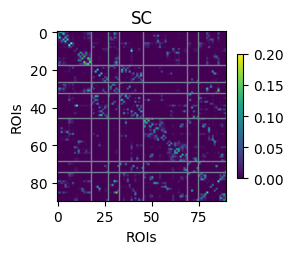

In [3]:
plt.figure(figsize=(3,3,))
plt.imshow(SC[order_mat].T)
plt.colorbar(shrink=0.5)
plt.title('SC')
plt.xlabel('ROIs')
plt.ylabel('ROIs')

# --- compute boundaries between networks ---
boundaries = np.where(np.diff(RSN_ordered) != 0)[0] + 1
# --- draw separator lines ---
for b in boundaries:
    plt.axhline(b - 0.5, color='slategray', lw=1)
    plt.axvline(b - 0.5, color='slategray', lw=1)
    
plt.tight_layout()
plt.show()

# Import fMRI data

In [4]:
# build the path relative to your notebook
file_path = os.path.join("../data/fmri/ts_coma24_AAL_symm.mat")
mat_data = sio.loadmat(file_path)

ts_controls = mat_data["timeseries_CNT24_symm"]
ts_mcs      = mat_data["timeseries_MCS24_symm"]
ts_uws      = mat_data["timeseries_UWS24_symm"]

# Unpack each group
controls = unpack_group(ts_controls)
mcs      = unpack_group(ts_mcs)
uws      = unpack_group(ts_uws)

# --- add preprocessing (k=2 Butterworth 0.01–0.08 Hz) plus zscore ---
controls = preprocess_groups(controls)
mcs      = preprocess_groups(mcs)
uws      = preprocess_groups(uws)

In [5]:
T=mcs[0].shape[0]   # time points
N=mcs[0].shape[1]   # number of regions
tri_N=np.triu_indices(N,1)
tri_T=np.triu_indices(T,1)

groups = {"CNT": controls, "MCS": mcs, "UWS": uws}
groups_id = list(groups.keys())

cols = {"CNT": "#DCA258", "MCS": "#AA7798", "UWS": "#524F88"}
markers = {"CNT": "o", "MCS": "s", "UWS": "^"}

# Load simulated connectivities

### you can directly load the above results from the online repo

https://amubox.univ-amu.fr/s/7rDDEBeH5eaiKpb

Place these files in results/ folder then proceed 

In [6]:
import os
import pickle

# ----------------------------------------------------------------------
# Define results directory
# ----------------------------------------------------------------------
results_dir = os.path.join("..", "results")

# ----------------------------------------------------------------------
# Helper function to load a .pkl dictionary
# ----------------------------------------------------------------------
def load_dict(name):
    path = os.path.join(results_dir, f"{name}.pkl")
    if not os.path.exists(path):
        print(f"⚠️  File not found: {path}")
        return None
    with open(path, "rb") as f:
        obj = pickle.load(f)
    print(f"✅ Loaded {name} from {path}")
    return obj

# ----------------------------------------------------------------------
# Load all result dictionaries
# ----------------------------------------------------------------------
Baseline_t_dict    = load_dict("Baseline_t")
Baseline_tp1_dict  = load_dict("Baseline_tp1")
Effect_nl_tp1_dict = load_dict("Effect_nl_tp1")
Effect_l_tp1_dict  = load_dict("Effect_l_tp1")
ECts_dict          = load_dict("ECts")
Jts_dict           = load_dict("Jts")
BECts_l2_dict      = load_dict("BECts_l2")
BECts_cos_dict     = load_dict("BECts_cos")

print("\nAll available dictionaries successfully loaded.")

✅ Loaded Baseline_t from ../results/Baseline_t.pkl
✅ Loaded Baseline_tp1 from ../results/Baseline_tp1.pkl
✅ Loaded Effect_nl_tp1 from ../results/Effect_nl_tp1.pkl
✅ Loaded Effect_l_tp1 from ../results/Effect_l_tp1.pkl
✅ Loaded ECts from ../results/ECts.pkl
✅ Loaded Jts from ../results/Jts.pkl
✅ Loaded BECts_l2 from ../results/BECts_l2.pkl
✅ Loaded BECts_cos from ../results/BECts_cos.pkl

All available dictionaries successfully loaded.


# Analyze state dependence

In [10]:
import numpy as np
import pandas as pd

# ----------------------------
# Helpers
# ----------------------------

def _offdiag_mask(n):
    m = np.ones((n,n), dtype=bool)
    np.fill_diagonal(m, False)
    return m

def signed_ratio(A):
    """
    Ratio of positive to negative edges (exclude diagonal).
    Returns: {'pos_frac': f_pos, 'neg_frac': f_neg, 'ratio_pos_over_neg': r}
    """
    n = A.shape[0]
    mask = _offdiag_mask(n)
    vals = A[mask]
    n_pos = np.sum(vals > 0)
    n_neg = np.sum(vals < 0)
    tot   = n_pos + n_neg
    if tot == 0:
        return dict(pos_frac=np.nan, neg_frac=np.nan, ratio_pos_over_neg=np.nan)
    f_pos = n_pos / tot
    f_neg = n_neg / tot
    r = (n_pos / n_neg) if n_neg > 0 else np.inf
    return dict(pos_frac=f_pos, neg_frac=f_neg, ratio_pos_over_neg=r)

def mean_abs_offdiag(A):
    n = A.shape[0]
    mask = _offdiag_mask(n)
    vals = np.abs(A[mask])
    return np.nan if vals.size == 0 else float(vals.mean())

# --------- Lightweight spectral modularity (undirected, weighted) ---------
# Uses |W| symmetrized to be robust to sign; recursive bisection until ΔQ <= 0.
import bct

import numpy as np
import bct

def modularity_louvain(W):
    """
    Safe Louvain modularity wrapper for weighted undirected networks.
    Cleans input, retries on failure, and falls back gracefully.
    """
    try:
        # --- Clean matrix ---
        W = np.array(W, float)
        W = np.nan_to_num(W)                   # remove NaN
        W = 0.5 * (W + W.T)                    # symmetrize
        W = np.abs(W)                          # ensure nonnegative
        np.fill_diagonal(W, 0.0)
        
        # remove very small weights
        W[W < 1e-8] = 0
        
        # normalize weights if needed (helps convergence)
        if W.max() > 0:
            W = W / W.max()

        # --- Try Louvain ---
        Ci, Q = bct.modularity_louvain_und(W, seed=42)
        if np.isfinite(Q):
            return float(Q)

        # --- Retry with gamma parameter tweak (optional) ---
        Ci, Q = bct.modularity_louvain_und(W, gamma=0.9, seed=42)
        if np.isfinite(Q):
            return float(Q)

    except Exception as e:
        print(f"[Warning] Louvain modularity failed: {e}")

    # --- Fallback: simple spectral modularity ---
    try:
        Q = modularity_spectral(W)
        print("[Info] Fallback to spectral modularity.")
        return float(Q)
    except Exception:
        return np.nan



# ----------------------------
# Nonlinearity (EC vs J)
# ----------------------------
def nonlinearity_metrics(EC, J):
    """
    Compare two (N,N) matrices at time t:
    - abs_diff_mean: mean |EC - J| off-diagonal
    - rel_fro_error: ||EC - J||_F / (||EC||_F + tiny)
    - edge_cos_sim: cosine similarity between vec(EC_offdiag) and vec(J_offdiag)
    """
    n = EC.shape[0]
    mask = _offdiag_mask(n)
    e = EC[mask].astype(float).ravel()
    j = J[mask].astype(float).ravel()

    diff = e - j
    abs_diff_mean = float(np.mean(np.abs(diff))) if diff.size else np.nan

    fro = lambda x: float(np.linalg.norm(x))
    rel_fro_error = fro(diff) / (fro(e) + 1e-12) if e.size else np.nan

    num = float(np.dot(e, j))
    den = (fro(e) * fro(j)) + 1e-12
    edge_cos_sim = num / den
    return dict(abs_diff_mean=abs_diff_mean,
                rel_fro_error=rel_fro_error,
                edge_cos_sim=edge_cos_sim)

# ----------------------------
# Per-time metrics from one (M,N,N) tensor
# ----------------------------
def ec_like_metrics_over_time(T3):
    """
    Generic for ECts or Jts (M,N,N):
    returns dict of arrays length M with keys:
      pos_frac, neg_frac, ratio_pos_over_neg, mean_abs, modularity_Q
    """
    M, N, _ = T3.shape
    pos_frac = np.empty(M); neg_frac = np.empty(M); ratio = np.empty(M)
    mean_abs = np.empty(M); Q = np.empty(M)
    for t in range(M):
        A = T3[t]
        sr = signed_ratio(A)
        pos_frac[t] = sr['pos_frac']; neg_frac[t] = sr['neg_frac']; ratio[t] = sr['ratio_pos_over_neg']
        mean_abs[t] = mean_abs_offdiag(A)
        Q[t] = modularity_louvain(A)
    return dict(pos_frac=pos_frac, neg_frac=neg_frac, ratio_pos_over_neg=ratio,
                mean_abs=mean_abs, modularity_Q=Q)

def bec_metrics_over_time(T3):
    """
    For BECts_* (M,N,N) (nonnegative expected):
    returns dict of arrays length M with keys:
      mean, var, modularity_Q
    """
    M, N, _ = T3.shape
    mean_ = np.empty(M); var_ = np.empty(M); Q = np.empty(M)
    mask = _offdiag_mask(N)
    for t in range(M):
        A = T3[t]
        vals = A[mask]
        mean_[t] = float(vals.mean()) if vals.size else np.nan
        var_[t]  = float(vals.var())  if vals.size else np.nan
        Q[t] = modularity_louvain(A)
    return dict(mean=mean_, var=var_, modularity_Q=Q)

# ----------------------------
# Main extractor over your dict[group][subject] structure
# ----------------------------
def summarize_all_metrics(
    Baseline_t_dict, ECts_dict, Jts_dict, BECts_l2_dict, BECts_cos_dict
):
    """
    Iterate group/subject dicts and build a tidy DataFrame with per-time metrics.
    Assumes same (M,N,N) shapes across EC/J/BEC within a subject; M can vary across subjects.
    """
    rows = []
    for g in ECts_dict.keys():
        for s in ECts_dict[g].keys():
            ECts = ECts_dict[g][s]          # (M,N,N)
            Jts  = Jts_dict[g][s]           # (M,N,N)
            BEC_l2  = BECts_l2_dict[g][s]   # (M,N,N)
            BEC_cos = BECts_cos_dict[g][s]  # (M,N,N)
            Baseline_t = Baseline_t_dict[g][s]  # (M,N)

            M, N, _ = ECts.shape

            # Baseline energy per time
            energy = np.sum(Baseline_t**2, axis=1)  # (M,)

            # EC/J metrics
            ec_m = ec_like_metrics_over_time(ECts)
            j_m  = ec_like_metrics_over_time(Jts)

            # Nonlinearity metrics per time
            nl_abs = np.empty(M); nl_rel = np.empty(M); nl_cos = np.empty(M)
            for t in range(M):
                nm = nonlinearity_metrics(ECts[t], Jts[t])
                nl_abs[t] = nm['abs_diff_mean']
                nl_rel[t] = nm['rel_fro_error']
                nl_cos[t] = nm['edge_cos_sim']

            # BEC metrics
            bec_l2_m  = bec_metrics_over_time(BEC_l2)
            bec_cos_m = bec_metrics_over_time(BEC_cos)

            # Pack rows
            for t in range(M):
                rows.append(dict(
                    group=g, subject=s, t=t,
                    energy=energy[t],

                    # EC
                    EC_pos_frac=ec_m['pos_frac'][t],
                    EC_neg_frac=ec_m['neg_frac'][t],
                    EC_pos_over_neg=ec_m['ratio_pos_over_neg'][t],
                    EC_mean_abs=ec_m['mean_abs'][t],
                    EC_modularity=ec_m['modularity_Q'][t],

                    # J
                    J_pos_frac=j_m['pos_frac'][t],
                    J_neg_frac=j_m['neg_frac'][t],
                    J_pos_over_neg=j_m['ratio_pos_over_neg'][t],
                    J_mean_abs=j_m['mean_abs'][t],
                    J_modularity=j_m['modularity_Q'][t],

                    # Nonlinearity (EC vs J)
                    NL_abs_mean=nl_abs[t],
                    NL_rel_fro=nl_rel[t],
                    NL_edge_cos=nl_cos[t],

                    # BEC (l2)
                    BEC_l2_mean=bec_l2_m['mean'][t],
                    BEC_l2_var=bec_l2_m['var'][t],
                    BEC_l2_modularity=bec_l2_m['modularity_Q'][t],

                    # BEC (cos)
                    BEC_cos_mean=bec_cos_m['mean'][t],
                    BEC_cos_var=bec_cos_m['var'][t],
                    BEC_cos_modularity=bec_cos_m['modularity_Q'][t],
                ))
    return pd.DataFrame(rows)

In [11]:
# ----------------------------
# Example usage (adjust to your variable names)
# ----------------------------
metrics_df = summarize_all_metrics(Baseline_t_dict, ECts_dict, Jts_dict, BECts_l2_dict, BECts_cos_dict)

In [12]:
# ----------------------------
# Correlation with baseline energy
# ----------------------------

def corr_by_group_subject(df, baseline_col='energy', exclude_cols=('t', 'group', 'subject')):
    """
    Compute Pearson correlation between baseline_col and each numeric effect metric,
    separately for each (group, subject).

    Returns:
        corrs[group][subject][metric] = correlation_value
    """
    def pearson_r(x, y):
        m = np.isfinite(x) & np.isfinite(y)
        x, y = x[m], y[m]
        if len(x) < 3:
            return np.nan
        x = x - x.mean()
        y = y - y.mean()
        denom = (np.linalg.norm(x) * np.linalg.norm(y)) + 1e-12
        return float(np.dot(x, y) / denom)

    corrs = {}
    num_cols = df.select_dtypes(include=[np.number]).columns
    effect_cols = [c for c in num_cols if c not in (*exclude_cols, baseline_col)]

    for g, gdf in df.groupby('group'):
        corrs[g] = {}
        for s, sdf in gdf.groupby('subject'):
            corrs[g][s] = {}
            x = sdf[baseline_col].values
            for col in effect_cols:
                y = sdf[col].values
                corrs[g][s][col] = pearson_r(x, y)
    return corrs

In [13]:
corrs = corr_by_group_subject(metrics_df)

In [14]:
import numpy as np
import pandas as pd

def permutation_test_correlations(
    df,
    baseline_col='energy',
    n_perm=1000,
    exclude_cols=('t','group','subject'),
    random_state=None,
    verbose=True
):
    """
    Permutation test for correlation between baseline_col and each effect metric
    within each (group, subject).

    Returns:
        results_df: tidy DataFrame with
            ['group','subject','metric','r_obs','p_value','z_score']
    """
    rng = np.random.default_rng(random_state)

    def pearson_r(x, y):
        x, y = np.log(np.asarray(x, float) + 1e-12), np.log(np.asarray(y, float) + 1e-12)
        m = np.isfinite(x) & np.isfinite(y)
        if m.sum() < 3: 
            return np.nan
        x, y = x[m] - x[m].mean(), y[m] - y[m].mean()
        return float(np.dot(x, y) / (np.linalg.norm(x) * np.linalg.norm(y) + 1e-12))


    num_cols = df.select_dtypes(include=[np.number]).columns
    effect_cols = [c for c in num_cols if c not in (*exclude_cols, baseline_col)]

    results = []

    for (g, s), sdf in df.groupby(['group','subject']):
        x = sdf[baseline_col].values
        if verbose:
            print(f"Testing {g} / {s} (n={len(x)} samples)")
        for col in effect_cols:
            y = sdf[col].values
            r_obs = pearson_r(x, y)
            if not np.isfinite(r_obs):
                continue
            # permutation null
            r_perm = np.empty(n_perm)
            for k in range(n_perm):
                x_shuf = rng.permutation(x)
                r_perm[k] = pearson_r(x_shuf, y)
            # two-tailed p-value
            p_val = np.mean(np.abs(r_perm) >= np.abs(r_obs))
            # z-score vs null
            mu, sigma = np.mean(r_perm), np.std(r_perm)
            z = (r_obs - mu) / (sigma + 1e-12)
            results.append(dict(group=g, subject=s, metric=col,
                                r_obs=r_obs, p_value=p_val, z_score=z))
    return pd.DataFrame(results)


In [15]:
perm_results = permutation_test_correlations(metrics_df, n_perm=1000, random_state=42)

Testing CNT / 0 (n=189 samples)
Testing CNT / 1 (n=189 samples)
Testing CNT / 2 (n=189 samples)
Testing CNT / 3 (n=189 samples)
Testing CNT / 4 (n=189 samples)
Testing CNT / 5 (n=189 samples)
Testing CNT / 6 (n=189 samples)
Testing CNT / 7 (n=189 samples)
Testing CNT / 8 (n=189 samples)
Testing CNT / 9 (n=189 samples)
Testing CNT / 10 (n=189 samples)
Testing CNT / 11 (n=189 samples)
Testing CNT / 12 (n=189 samples)
Testing MCS / 0 (n=189 samples)
Testing MCS / 1 (n=189 samples)
Testing MCS / 2 (n=189 samples)
Testing MCS / 3 (n=189 samples)
Testing MCS / 4 (n=189 samples)
Testing MCS / 5 (n=189 samples)
Testing MCS / 6 (n=189 samples)
Testing MCS / 7 (n=189 samples)
Testing MCS / 8 (n=189 samples)
Testing MCS / 9 (n=189 samples)
Testing MCS / 10 (n=189 samples)
Testing UWS / 0 (n=189 samples)
Testing UWS / 1 (n=189 samples)
Testing UWS / 2 (n=189 samples)
Testing UWS / 3 (n=189 samples)
Testing UWS / 4 (n=189 samples)
Testing UWS / 5 (n=189 samples)
Testing UWS / 6 (n=189 samples)
Test

<Axes: xlabel='p_value', ylabel='Count'>

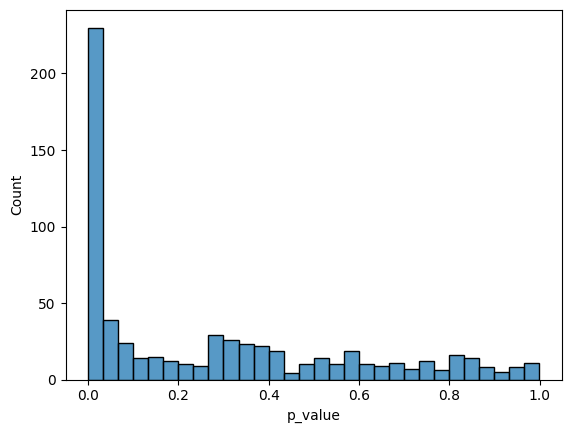

In [16]:
# Significance summary
(perm_results['p_value'] < 0.05).groupby(perm_results['group']).mean()

# Visualize
import seaborn as sns
sns.histplot(perm_results['p_value'], bins=30)


In [51]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def visualize_perm_results(perm_df, alpha=0.05, use_r2=False):
    """
    Visualize permutation-test correlations with custom group colors & markers.
    Optionally display r**2 instead of r.

    Parameters
    ----------
    perm_df : pd.DataFrame
        DataFrame with ['group', 'subject', 'metric', 'r_obs', 'p_value'].
    alpha : float
        Significance threshold.
    use_r2 : bool
        If True, use r**2 (coefficient of determination) instead of r.
    """
    sns.set_theme(style="whitegrid", context="talk")

    # Custom palette & markers
    cols = {"CNT": "#DCA258", "MCS": "#AA7798", "UWS": "#524F88"}
    markers = {"CNT": "o", "MCS": "s", "UWS": "^"}

    # --- If using r², transform and rename variable ---
    if use_r2:
        perm_df = perm_df.copy()
        perm_df["r_obs"] = perm_df["r_obs"] ** 2
        corr_label = "Mean r² (obs)"
        dist_ylabel = "Observed r²"
        title_corr = "Mean observed correlation (r²) per group"
    else:
        corr_label = "Mean r (obs)"
        dist_ylabel = "Observed r"
        title_corr = "Mean observed correlation (r) per group"

    # ---- 1️⃣ Heatmaps ----
    pivot_mean = perm_df.pivot_table(index="metric", columns="group", values="r_obs", aggfunc="mean")
    pivot_sig = perm_df.pivot_table(index="metric", columns="group",
                                    values="p_value", aggfunc=lambda x: np.mean(np.array(x) < alpha))

    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    sns.heatmap(pivot_mean, ax=axes[0], center=0 if not use_r2 else None,
                cmap="coolwarm", annot=True, fmt=".2f",
                cbar_kws={'label': corr_label})
    axes[0].set_title(title_corr)

    sns.heatmap(pivot_sig, ax=axes[1], cmap="YlGnBu_r", annot=True, fmt=".0%",
                cbar_kws={'label': f'Fraction significant (p<{alpha})'})
    axes[1].set_title("Significance rate across subjects")
    plt.tight_layout()

    # ---- 2️⃣ Distribution plot (clean separation) ----
    plt.figure(figsize=(12, 5))
    sns.boxplot(data=perm_df, x="metric", y="r_obs", hue="group",
                palette=cols, showfliers=False, width=0.6, dodge=True)

    groups = perm_df["group"].unique()
    for g in groups:
        sub = perm_df[perm_df["group"] == g]
        sns.stripplot(
            data=sub, x="metric", y="r_obs",
            color=cols[g], marker=markers[g],
            edgecolor="k", linewidth=0.5, size=3,
            dodge=True, alpha=0.75
        )

    plt.axhline(0, color='k', ls='--', lw=1)
    plt.title(f"Observed {'r²' if use_r2 else 'r'} by metric and group")
    plt.ylabel(dist_ylabel)
    #plt.legend(title="Group", bbox_to_anchor=(1.02, 1), loc="upper left")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()

    # ---- 3️⃣ Fraction of significant subjects ----
    sig_df = (perm_df.assign(sig=perm_df["p_value"] < alpha)
              .groupby(["group", "metric"])["sig"].mean()
              .reset_index())

    plt.figure(figsize=(10, 4))
    sns.barplot(data=sig_df, x="metric", y="sig", hue="group",
                palette=cols, edgecolor="k", linewidth=0.5)
    plt.title(f"Fraction of subjects with significant correlation (p<{alpha})")
    plt.ylabel("Fraction significant")
    plt.ylim(0, 1)
    plt.xticks(rotation=45, ha='right')
    plt.legend(title="Group", bbox_to_anchor=(1.02, 1), loc="upper left")
    plt.tight_layout()

    plt.show()


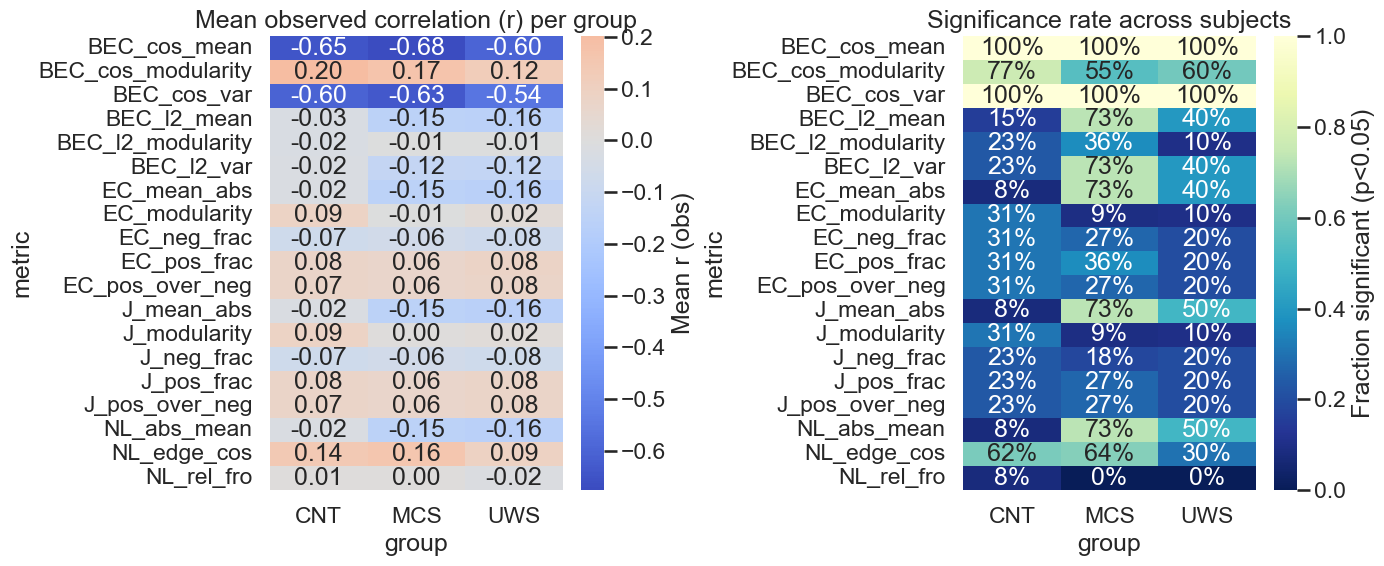

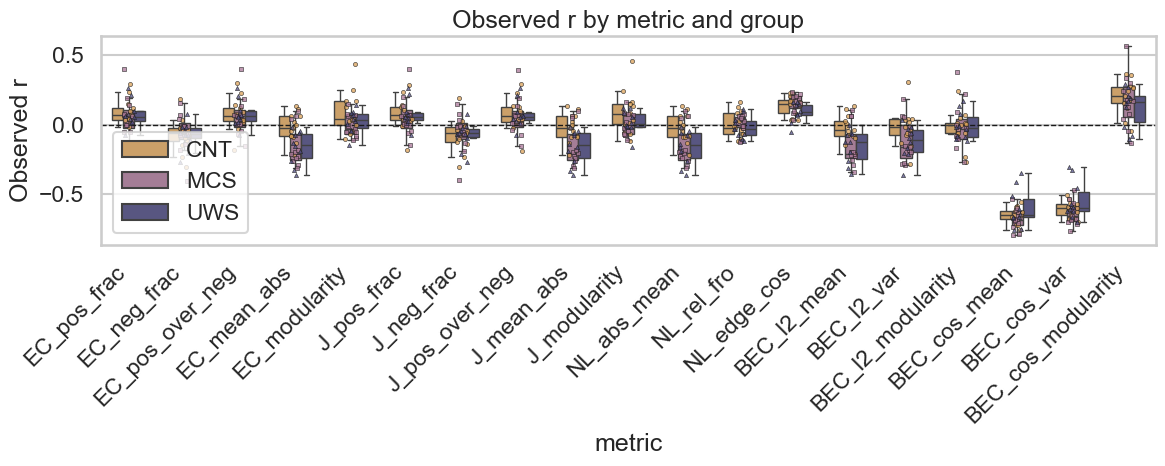

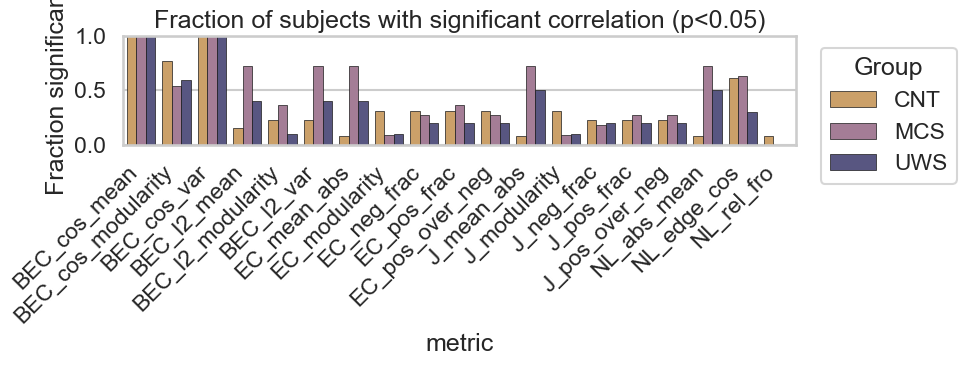

In [52]:
visualize_perm_results(perm_results, alpha=0.05,use_r2=False)

In [53]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def plot_subject_baseline_vs_metric(
    metrics_df, group="CNT", subject_idx=0, metric="BEC_cos_mean",
    logx=True, logy=True
):
    """
    Plot baseline energy vs. a selected effect metric for one subject and group,
    with optional log-transform on x and/or y.

    Parameters
    ----------
    metrics_df : pd.DataFrame
        DataFrame containing ['group', 'subject', 'energy', metric].
    group : str
        Group name (e.g., 'CNT').
    subject_idx : int
        Index of the subject within the group.
    metric : str
        Column name for the effect metric.
    logx, logy : bool
        Whether to apply logarithmic transform to x and/or y before fitting and plotting.
    """
    sns.set_theme(style="whitegrid", context="talk")

    # --- Extract subject data ---
    sub_id = list(metrics_df[metrics_df["group"] == group]["subject"].unique())[subject_idx]
    sub_df = metrics_df[(metrics_df["group"] == group) & (metrics_df["subject"] == sub_id)]

    # --- Handle possible log transform ---
    sub_df = sub_df.copy()
    if logx:
        sub_df = sub_df[sub_df["energy"] > 0]
        x = np.log(sub_df["energy"])
        xlabel = "Baseline energy (Σ x(t)², log scale)"
    else:
        x = sub_df["energy"]
        xlabel = "Baseline energy (Σ x(t)²)"

    if logy:
        sub_df = sub_df[sub_df[metric] > 0]
        y = np.log(sub_df[metric])
        ylabel = f"{metric} (log scale)"
    else:
        y = sub_df[metric]
        ylabel = metric

    # --- Fit linear regression in the chosen space ---
    p = np.polyfit(x, y, 1)
    r = np.corrcoef(x, y)[0, 1]
    xfit = np.linspace(x.min(), x.max(), 100)
    yfit = np.polyval(p, xfit)

    # --- Prepare for plotting back in normal scale ---
    def inv(val, log_flag):
        return np.exp(val) if log_flag else val

    xplot, yplot = inv(x, logx), inv(y, logy)
    xfit_plot, yfit_plot = inv(xfit, logx), inv(yfit, logy)

    # --- Plot ---
    plt.figure(figsize=(6,5))
    sns.scatterplot(x=xplot, y=yplot, s=60, color="#DCA258", edgecolor="k", alpha=0.8)
    plt.plot(xfit_plot, yfit_plot, "k-", lw=1.5)

    # --- Axes scaling ---
    if logx:
        plt.xscale("log")
    if logy:
        plt.yscale("log")

    # --- Labels & title ---
    title_suffix = f"{'log' if logx else 'lin'}–{'log' if logy else 'lin'}"
    plt.title(f"{group} - Subject {sub_id}\n{title_suffix} Baseline vs {metric} (r = {r:.2f})")
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.tight_layout()
    plt.show()


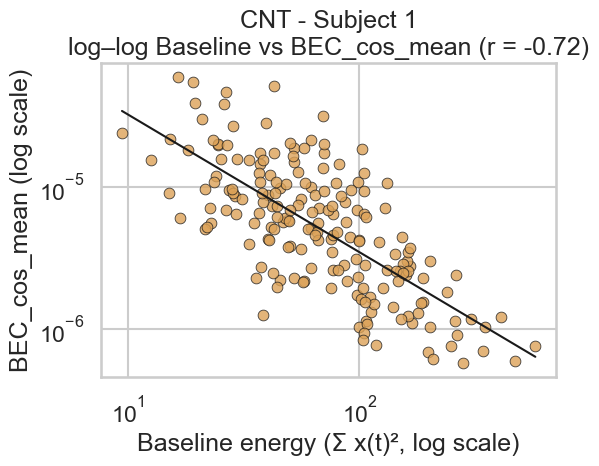

In [54]:
plot_subject_baseline_vs_metric(metrics_df, group="CNT", subject_idx=1, metric="BEC_cos_mean")

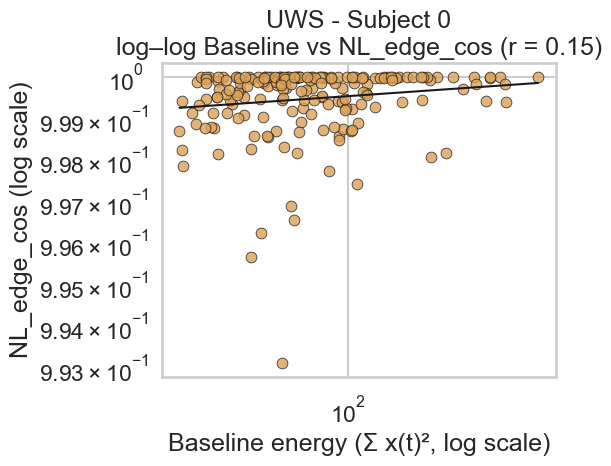

In [46]:
plot_subject_baseline_vs_metric(metrics_df, group="UWS", subject_idx=0, metric="NL_edge_cos", logx=True, logy=True)

In [55]:
import numpy as np
import pandas as pd
from scipy import stats
import scikit_posthocs as sp
import seaborn as sns
import matplotlib.pyplot as plt

def test_group_differences(perm_df, metric="BEC_cos_mean"):
    """
    Compare correlation strengths (r_obs) across groups for one metric.
    Performs normality check, ANOVA or Kruskal–Wallis + posthoc Dunn tests.
    Also plots group distributions.
    """
    sns.set_theme(style="whitegrid", context="talk")

    # --- Extract metric ---
    df = perm_df[perm_df["metric"] == metric].copy()

    # --- Basic sanity ---
    groups = df["group"].unique()
    print(f"Testing group differences for metric: {metric}")
    print(f"Groups: {groups}")

    # --- Normality test per group ---
    for g in groups:
        x = df.loc[df["group"] == g, "r_obs"].values
        if len(x) >= 3:
            w, p = stats.shapiro(x)
            print(f"  {g:>4}: Shapiro-Wilk W={w:.3f}, p={p:.3f}")

    # --- Nonparametric Kruskal–Wallis test ---
    data_by_group = [df.loc[df["group"] == g, "r_obs"].values for g in groups]
    H, p_kw = stats.kruskal(*data_by_group)
    print(f"\nKruskal–Wallis H={H:.3f}, p={p_kw:.4f}")

    # --- Posthoc pairwise Dunn test ---
    posthoc = sp.posthoc_dunn(df, val_col="r_obs", group_col="group", p_adjust="fdr_bh")
    print("\nPosthoc Dunn's test (FDR corrected):")
    print(posthoc)

    # --- Plot group distributions ---
    plt.figure(figsize=(6,5))
    palette = {"CNT": "#DCA258", "MCS": "#AA7798", "UWS": "#524F88"}
    sns.boxplot(data=df, x="group", y="r_obs", palette=palette, width=0.5)
    sns.stripplot(data=df, x="group", y="r_obs", palette=palette,
                  dodge=True, edgecolor="k", linewidth=0.5, size=7, alpha=0.8)
    plt.title(f"Group comparison: {metric}\nKruskal–Wallis p={p_kw:.3f}")
    plt.ylabel("Observed correlation (r_obs)")
    plt.tight_layout()
    plt.show()

    return {"kruskal": (H, p_kw), "posthoc": posthoc}


Testing group differences for metric: J_mean_abs
Groups: ['CNT' 'MCS' 'UWS']
   CNT: Shapiro-Wilk W=0.977, p=0.965
   MCS: Shapiro-Wilk W=0.812, p=0.014
   UWS: Shapiro-Wilk W=0.924, p=0.393

Kruskal–Wallis H=7.938, p=0.0189

Posthoc Dunn's test (FDR corrected):
          CNT       MCS       UWS
CNT  1.000000  0.026885  0.026885
MCS  0.026885  1.000000  0.994999
UWS  0.026885  0.994999  1.000000


/var/folders/8j/xj5x54bs757dw9vt37nb69l40000gn/T/ipykernel_1351/3027074872.py:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="group", y="r_obs", palette=palette, width=0.5)
/var/folders/8j/xj5x54bs757dw9vt37nb69l40000gn/T/ipykernel_1351/3027074872.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(data=df, x="group", y="r_obs", palette=palette,


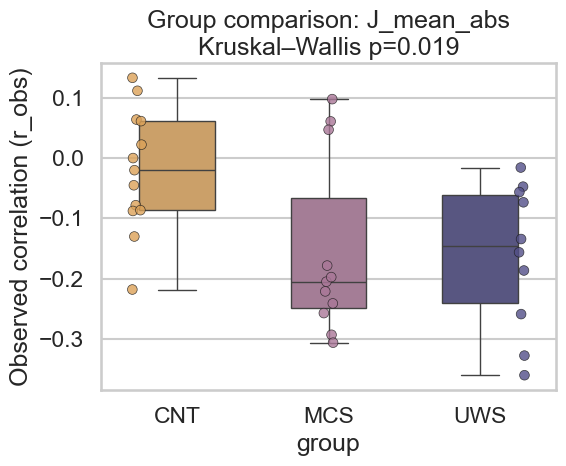

In [56]:
results = test_group_differences(perm_results, metric="J_mean_abs")
